# Descrição do problema

O Billion Bank é um banco digital brasileiro, fundado em 2021. Trabalha hoje com contas digitais, e cartões de crédito.

Quando um cliente solicita aumento de limite no cartão de crédito, o banco consulta uma empresa de crédito terceira, que retorna uma recomendação: "negar" ou "conceder". Essa resposta é repassada ao cliente.

Dado que a empresa de crédito precisa levantar maiores informações de histórico financeiro do cliente com terceiros, o retorno da recomendação ao banco leva até 5 dias úteis!

Tratando-se de um serviço, a cada solicitação de aumento de limite feita por um cliente, o banco tem um custo adicional de consulta. Visando reduzir este custo, em 2022, o banco passou a só aceitar novos pedidos de aumento de limite a cada 3 meses.

O banco viu um aumento leve do churn no primeiro semestre, que se acentuou mais no segundo, chegando a um ponto já preocupante. O time de CS fez contato com antigos clientes, e constatou que o principal motivo do churn foi a percepção de burocracia relacionada ao aumento nos limites.

Para reverter o cenário, o banco traçou um plano de ação com dois objetivos:
1. Desburocratizar o processo, permitindo que o cliente possa solicitar um novo limite uma vez por semana, tendo uma resposta instantânea.
2. Desativar as consultas de recomendação de aumento de limites feitas hoje com a empresa terceira, que são demoradas e custosas.

Para concretizar o plano, foi solicitado ao time de cientistas de dados, que com base no histórico de recomendações ("negar" ou "conceder") da empresa de crédito, aliado ao histórico financeiro dos clientes, desenvolvam um modelo de avaliação de aumento de limite de cartão de crédito dentro de casa.

O modelo de classificação, deve informar se o Billion Bank deve "negar" ou "conceder" o aumento no limite solicitado pelo cliente.

# 0. Importações e leitura dos dados

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from boruta import BorutaPy
import matplotlib.pyplot as plt
# from scipy import stats
# from datetime import datetime
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split, cross_validate
# from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, make_scorer
# from sklearn.linear_model import LinearRegression, Lasso
# from xgboost import XGBRegressor

from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer

from sklearn.metrics import classification_report
# from sklearn.metrics import plot_confusion_matrix

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

c:\Users\joao.antunes\AppData\Local\miniconda3\envs\ambienteds\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 0.1. Funções

In [4]:
def avaliar(model, X, y, n_splits=5, random_state=None):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # validação cruzada
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=kf,
        scoring=("f1_weighted", "recall_weighted", "precision_weighted")
    )
    # calcula métricas
    f1_weighted = cv_results['test_f1_weighted']
    recall_weighted = cv_results['test_recall_weighted']
    precision_weighted = cv_results['test_precision_weighted']
    
    # printa
    print(
        f"***Modelo: {model.__class__.__name__}***\n"
        f"F1: {f1_weighted.mean():.3f} ± {f1_weighted.std():.3f}\n"
        f"Recall: {recall_weighted.mean():.3f} ± {recall_weighted.std():.3f}\n"
        f"Precision: {precision_weighted.mean():.3f} ± {precision_weighted.std():.3f}\n"
    )

def tendencia_central(num_attributes):
    # Tendencia central - mean, ]median
    ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

    # Dispersão - std, min, max, range, knew, kurtosis
    d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
    d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
    d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
    d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
    d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
    d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

    #Concatenar
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns =['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

    return m

## 0.2. Leitura dos dados

In [5]:
df_raw = pd.read_csv('train.csv')
df_validacao = pd.read_csv('test.csv')

# 1.0. Descrição dos Dados

In [6]:
df1 = df_raw.copy()

In [7]:
df1.columns

Index(['id_cliente', 'idade', 'saldo_atual', 'divida_atual', 'renda_anual',
       'valor_em_investimentos', 'taxa_utilizacao_credito', 'num_emprestimos',
       'num_contas_bancarias', 'num_cartoes_credito', 'dias_atraso_dt_venc',
       'num_pgtos_atrasados', 'num_consultas_credito', 'taxa_juros',
       'investe_exterior', 'pessoa_polit_exp', 'limite_adicional'],
      dtype='object')

In [8]:
df1.head()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
0,1767,21,278.172008,2577.05,24196.89636,104.306544,31.038763,6,5,7,21,14,9,15,Não,Não,Negar
1,11920,40,268.874152,2465.39,19227.37796,69.858778,36.917093,5,8,5,40,23,10,18,Não,Não,Negar
2,8910,36,446.643127,1055.29,42822.28223,134.201478,34.561714,0,3,6,26,13,3,15,Sim,Não,Negar
3,4964,58,321.141267,703.05,51786.82600,297.350067,31.493561,0,3,7,12,7,2,1,Sim,Não,Negar
4,10100,35,428.716114,891.29,44626.85346,134.201478,28.028887,2,8,7,24,10,8,20,Sim,Não,Negar


## 1.1. Dimensão dos Dados

In [9]:
# treino
print(f'Linhas: {df1.shape[0]}')
print(f'Colunas: {df1.shape[1]}')

Linhas: 9500
Colunas: 17


In [10]:
# teste
print(f'Linhas: {df_validacao.shape[0]}')
print(f'Colunas: {df_validacao.shape[1]}')

Linhas: 3000
Colunas: 16


## 1.2. Tipos de dados

In [11]:
df1.dtypes

id_cliente                   int64
idade                        int64
saldo_atual                float64
divida_atual               float64
renda_anual                float64
valor_em_investimentos     float64
taxa_utilizacao_credito    float64
num_emprestimos              int64
num_contas_bancarias         int64
num_cartoes_credito          int64
dias_atraso_dt_venc          int64
num_pgtos_atrasados          int64
num_consultas_credito        int64
taxa_juros                   int64
investe_exterior            object
pessoa_polit_exp            object
limite_adicional            object
dtype: object

## 1.3. Check NA

In [12]:
df1.isna().sum()

id_cliente                 0
idade                      0
saldo_atual                0
divida_atual               0
renda_anual                0
valor_em_investimentos     0
taxa_utilizacao_credito    0
num_emprestimos            0
num_contas_bancarias       0
num_cartoes_credito        0
dias_atraso_dt_venc        0
num_pgtos_atrasados        0
num_consultas_credito      0
taxa_juros                 0
investe_exterior           0
pessoa_polit_exp           0
limite_adicional           0
dtype: int64

## 1.4. Estatística Descritiva

In [13]:
num_attr = df1.select_dtypes(include=['int64', 'int32', 'float64'])
cat_attr = df1.select_dtypes(exclude=['int64', 'int32', 'float64'])

## 1.4.1 Atributos Numéricos

In [14]:
num_attr.describe().T

,count,mean,std,min,25%,50%,75%,max
id_cliente,9500.0,6210.532947,3.603244e+03,1.000000,3091.750000,6172.500000,9320.250000,1.250000e+04
idade,9500.0,126.398421,6.850360e+02,18.000000,28.000000,38.000000,47.000000,8.598000e+03
saldo_atual,9500.0,404.532032,2.176967e+02,0.088628,272.363060,337.169588,471.264657,1.602041e+03
divida_atual,9500.0,1437.086420,1.156263e+03,0.230000,573.620000,1175.730000,1963.332500,4.998070e+03
renda_anual,9500.0,195037.274234,1.454274e+06,10473.865350,26207.900390,45991.106000,80449.829250,2.327966e+07
valor_em_investimentos,9500.0,611.999323,2.002444e+03,0.000000,76.083981,134.201478,249.182915,1.000000e+04
taxa_utilizacao_credito,9500.0,32.270823,5.106053e+00,20.992914,28.078872,32.262649,36.464575,4.956452e+01
num_emprestimos,9500.0,10.863684,6.255542e+01,0.000000,2.000000,3.000000,6.000000,1.496000e+03
num_contas_bancarias,9500.0,17.552316,1.209802e+02,0.000000,3.000000,6.000000,7.000000,1.779000e+03
num_cartoes_credito,9500.0,21.433158,1.226774e+02,1.000000,4.000000,6.000000,7.000000,1.479000e+03


In [15]:
tendencia_central(num_attr)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id_cliente,1.000000,1.250000e+04,1.249900e+04,6210.532947,6172.500000,3.603054e+03,0.014114,-1.199109
1,idade,18.000000,8.598000e+03,8.580000e+03,126.398421,38.000000,6.849999e+02,9.092579,87.613308
2,saldo_atual,0.088628,1.602041e+03,1.601952e+03,404.532032,337.169588,2.176853e+02,1.621743,3.104578
3,divida_atual,0.230000,4.998070e+03,4.997840e+03,1437.086420,1175.730000,1.156202e+03,1.187913,0.848447
4,renda_anual,10473.865350,2.327966e+07,2.326918e+07,195037.274234,45991.106000,1.454197e+06,11.874057,149.389202
5,valor_em_investimentos,0.000000,1.000000e+04,1.000000e+04,611.999323,134.201478,2.002338e+03,4.436327,17.868001
6,taxa_utilizacao_credito,20.992914,4.956452e+01,2.857161e+01,32.270823,32.262649,5.105784e+00,0.042483,-0.915879
7,num_emprestimos,0.000000,1.496000e+03,1.496000e+03,10.863684,3.000000,6.255212e+01,16.366227,310.979754
8,num_contas_bancarias,0.000000,1.779000e+03,1.779000e+03,17.552316,6.000000,1.209738e+02,10.877721,123.218353
9,num_cartoes_credito,1.000000,1.479000e+03,1.478000e+03,21.433158,6.000000,1.226709e+02,8.564262,76.794957


* **idade**: A idade média é 126, com um máximo de 8.598, indicando valores errados inflando a média. A idade mediana de 38 é mais representativa dos dados.
* **saldo_atual**: O saldo atual varia de quase zero a 1.602, com uma média de 404,53, sugerindo que a maioria dos dados está agrupada na extremidade inferior.
* **divida_atual**: A dívida atual tem uma média de 1.437,09 com uma dispersão considerável, como visto no desvio padrão de 1.156,26.
* **renda_anual**: A renda anual média é muito alta, 195.037, devido a alguns valores muito altos (máximo de cerca de 23 milhões).
* **valor_em_investimentos**: O valor médio em investimentos é de 611,99, mas atinge até 10.000, indicando possíveis outliers ou alta variabilidade nos comportamentos de investimento dos clientes.
* **taxa_utilizacao_credito**: A taxa de utilização de crédito tem uma média de 32,27% com uma distribuição apertada, o que sugere que a maioria dos valores está agrupada em torno da média.
* **num_emprestimos**: O número de empréstimos varia muito, sugerindo possíveis outliers ou erros de dados.
* **num_contas_bancarias**: O número médio de contas bancárias está inflado em 17,55 devido a valores extremos até 1.779, indicando problemas de dados.
* **num_cartoes_credito**: O número médio de cartões de crédito, como as contas bancárias, é distorcido por valores máximos elevados (1.479), com uma mediana de 6.
* **dias_atraso_dt_venc**: Os dias de atraso na data de vencimento têm valores negativos (min -5), o que exige limpeza, pois dias de atraso não deveriam ser negativos.
* **num_pgtos_atrasados**: O número de pagamentos atrasados é altamente enviesado, com valores extremos de até 4.388, o que parece improvável e pode ser um erro.
* **num_consultas_credito**: As consultas de crédito mostram um padrão semelhante com possíveis problemas de qualidade de dados, dado o máximo de 2.589 contra uma mediana de 4.
* **taxa_juros**: A taxa de juros parece geralmente razoável, mas inclui valores máximos improváveis (5.788), sugerindo erros.

## 1.4.2 Atributos Categóricos

In [22]:
# Quantidade de itens diferentes por atributo.
cat_attr.investe_exterior.value_counts()

investe_exterior
Não    7177
Sim    2323
Name: count, dtype: int64

In [23]:
cat_attr.pessoa_polit_exp.value_counts()

pessoa_polit_exp
Não    8917
Sim     583
Name: count, dtype: int64

In [24]:
cat_attr.limite_adicional.value_counts()

limite_adicional
Negar       7995
Conceder    1505
Name: count, dtype: int64

# 2.0. Feature Engineering

In [ ]:
def feature_engeneering(df):
    df = df.copy()
    # idade
    df['idade'] = df['idade'].apply(lambda x: x if x <= 101 else df['idade'].quantile(0.95))

    # num_emprestimos
    df['num_emprestimos'] = df['num_emprestimos'].apply(lambda x: x if x <= df['num_emprestimos'].quantile(0.95) else df['num_emprestimos'].quantile(0.95))

    # num_contas_bancarias
    df['num_contas_bancarias'] = df['num_contas_bancarias'].apply(lambda x: x if x <= df['num_contas_bancarias'].quantile(0.95) else df['num_contas_bancarias'].quantile(0.95))

    # num_cartoes_credito
    df['num_cartoes_credito'] = df['num_cartoes_credito'].apply(lambda x: x if x <= df['num_cartoes_credito'].quantile(0.95) else df['num_cartoes_credito'].quantile(0.95))

    df['num_contas_bancarias'] = df['num_contas_bancarias'].apply(lambda x: x if x <= df['num_contas_bancarias'].quantile(0.95) else df['num_contas_bancarias'].quantile(0.99))
    df['num_consultas_credito'] = df['num_consultas_credito'].apply(lambda x: x if x <= df['num_consultas_credito'].quantile(0.98) else df['num_consultas_credito'].quantile(0.99))
    df['num_pgtos_atrasados'] = df['num_pgtos_atrasados'].apply(lambda x: x if x <= df['num_pgtos_atrasados'].quantile(0.99) else df['num_pgtos_atrasados'].quantile(0.99))
    df['taxa_juros'] = df['taxa_juros'].apply(lambda x: x if x <= df['taxa_juros'].quantile(0.98) else df['taxa_juros'].quantile(0.98))

    return df

In [ ]:
df2 = feature_engeneering(df1)
df_validacao = feature_engeneering(df_validacao)

In [ ]:
# sns.histplot(df2['taxa_juros'])

In [ ]:
# df2 = df_temp.copy()

In [ ]:
# # df_temp = df2.copy()
# df2['taxa_juros'] = df2['taxa_juros'].apply(lambda x: 0 if x <= 5
#                                                else 2 if x <= 10
#                                                else 3 if x <= 15
#                                                else 4 if x <= 20
#                                                else 5 if x <= 25
#                                                else 6 if x <= 30
#                                                else 7 if x <= 35
#                                                else 8 if x <= 100
#                                                else 9)
# sns.boxplot(data=df2, x='taxa_juros', y='limite_adicional')

In [ ]:
# df2['num_cartoes_credito'].describe()
# df2['num_cartoes_credito'][df2['num_cartoes_credito'] > 50]
# df2['num_cartoes_credito'].quantile(0.95)

## 3.0. Filtragem dos Dados

In [ ]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

VER:
- idade
- renda_anual
- num_emprestimos
- num_contas_bancarias
- num_cartoes_credito
- num_emprestimos
- num_pgtos_atrasados
- num_consultas_credito

In [ ]:
num_attr.columns

Index(['id_cliente', 'idade', 'saldo_atual', 'divida_atual', 'renda_anual',
       'valor_em_investimentos', 'taxa_utilizacao_credito', 'num_emprestimos',
       'num_contas_bancarias', 'num_cartoes_credito', 'dias_atraso_dt_venc',
       'num_pgtos_atrasados', 'num_consultas_credito', 'taxa_juros'],
      dtype='object')

## 3.2. Selecao das Colunas

In [ ]:
fetures_manuais = [
    'idade',
    'saldo_atual',
    'divida_atual',
    'renda_anual',
    'dias_atraso_dt_venc',
    'num_pgtos_atrasados']

In [ ]:
# [
#     'idade',
#     'saldo_atual',
#     'divida_atual',
#     'renda_anual',
#     'dias_atraso_dt_venc',
#     'num_pgtos_atrasados',
 
# 'valor_em_investimentos',
# 'taxa_utilizacao_credito',
# 'num_emprestimos',
# 'num_contas_bancarias', 
# 'num_cartoes_credito',
# 'num_consultas_credito',
# 'taxa_juros',
# 'investe_exterior',
# 'pessoa_polit_exp', 
# 'limite_adicional']

# 4.0. Análise Exploratória dos Dados - EDA

In [ ]:
df4 = df3.copy()
# df4 = df_raw.copy()

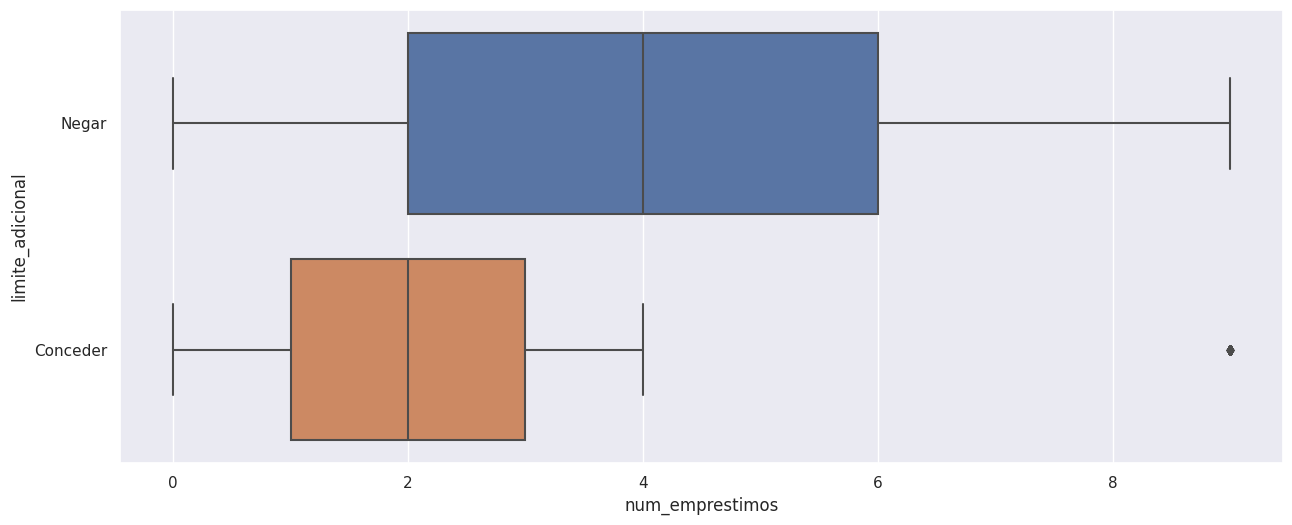

In [ ]:
sns.boxplot(data=df4, x='num_emprestimos', y='limite_adicional')

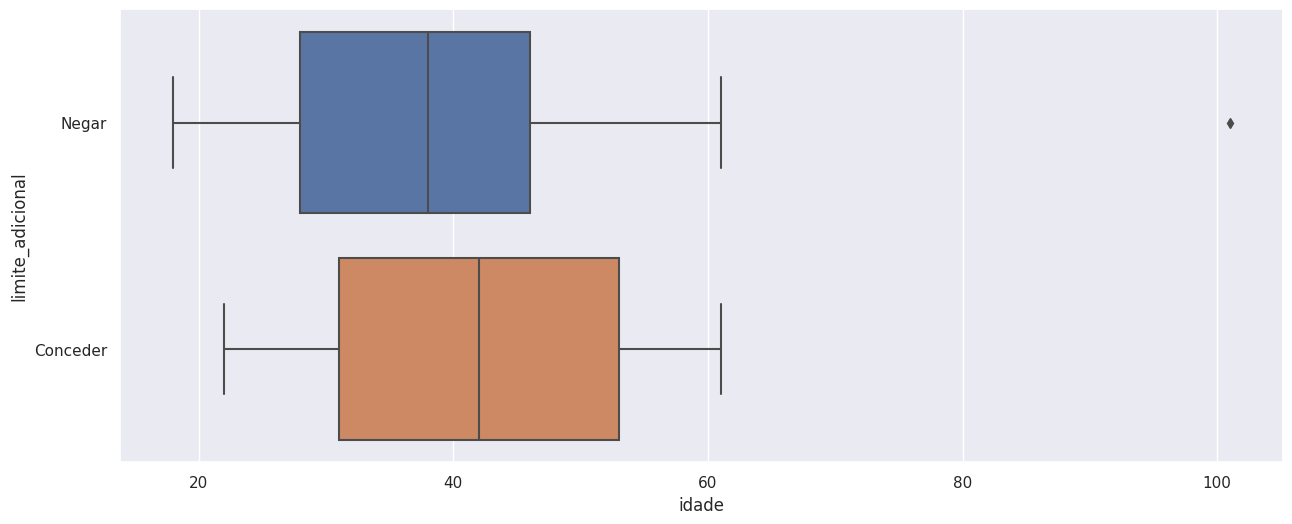

In [ ]:
sns.boxplot(data=df4[['idade','limite_adicional']], x='idade', y='limite_adicional')

## 4.1. Analise Univariada

### 4.1.1.Variável Resposta

### 4.1.2. Sweetviz

In [ ]:
import sweetviz as sv

In [ ]:
feature_viz = ['idade', 'saldo_atual', 'divida_atual', 'renda_anual',
       'valor_em_investimentos', 'taxa_utilizacao_credito', 'num_emprestimos',
       'num_contas_bancarias', 'num_cartoes_credito', 'dias_atraso_dt_venc',
       'num_pgtos_atrasados', 'num_consultas_credito', 'taxa_juros',
       'investe_exterior', 'pessoa_polit_exp', 'limite_adicional']

In [ ]:
df4['taxa_juros'].describe()

count   9500.00
mean      14.94
std        9.02
min        1.00
25%        8.00
50%       14.00
75%       20.00
max       34.00
Name: taxa_juros, dtype: float64

In [ ]:
df_viz = df4.copy()
df_modelo = df_raw.copy()

df_modelo['num_emprestimos'] = df_modelo['num_emprestimos'].apply(lambda x: x if x <= df_modelo['num_emprestimos'].quantile(0.95) else df_modelo['num_emprestimos'].quantile(0.95))
df_modelo['num_cartoes_credito'] = df_modelo['num_cartoes_credito'].apply(lambda x: x if x <= df_modelo['num_cartoes_credito'].quantile(0.95) else df_modelo['num_cartoes_credito'].quantile(0.95))

limite_adicional = {'Negar':0, 'Conceder':1}
df_modelo['limite_adicional'] = df_modelo['limite_adicional'].map(limite_adicional)

report = sv.analyze(source = df_modelo[feature_viz], target_feat = 'limite_adicional')
report.show_notebook()
# report.show_html()

### 4.1.2. Variável Numérica

In [ ]:
# num_attr = df2.select_dtypes(include=['int64', 'int32', 'float64'])
# num_attr.describe().T

### 4.1.3. Variável Categórica

## 4.2. Analise Bivariada

## 4.3. Analise Multivariada

### 4.3.1. Atributos Numéricos

### 4.3.2. Atributos Categóricos

# 5.0. Preparação dos Dados

In [ ]:
df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

## 5.3. Transformação

### 5.3.1. Encoding

In [ ]:
cat_transformer = Pipeline(steps=[
    ('one-hot encoder', OneHotEncoder())
])

### 5.3.2. Transformações de Natureza

## 5.4. Preprocessamento pipeline

In [ ]:
cat_attr.head()

,investe_exterior,pessoa_polit_exp,limite_adicional
0,Não,Não,Negar
1,Não,Não,Negar
2,Sim,Não,Negar
3,Sim,Não,Negar
4,Sim,Não,Negar


In [ ]:
preprocessor = ColumnTransformer(transformers=[
    # ('num', num_transformer, ['Age', 'Fare']),
    ('cat', cat_transformer, ['investe_exterior', 'pessoa_polit_exp'])
])

Estrutura do Pipeline

In [ ]:
# set up preprocessing for numeric columns
imp_median = SimpleImputer(strategy='median', add_indicator=True)
scaler = StandardScaler()

# set up preprocessing for categorical columns
imp_constant = SimpleImputer(strategy='constant')
ohe = OneHotEncoder(handle_unknown='ignore')

# select columns by data type
num_cols = make_column_selector(dtype_include='number')
cat_cols = make_column_selector(dtype_exclude='number')

# do all preprocessing
preprocessor = make_column_transformer(
    (make_pipeline(imp_median, scaler), num_cols),
    (make_pipeline(imp_constant, ohe), cat_cols))

# 6.0. Feature Selection

In [ ]:
df6 = df5.copy()

In [ ]:
# X_train1 = df6.drop(columns=['limite_adicional', 'id_cliente'], axis=1)
# y_train1 = df6['limite_adicional']

## 6.1. Boruta as feature selector

In [ ]:
# model_boruta = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('boruta', BorutaPy(
#             estimator=RandomForestClassifier(n_jobs=-1),
#             n_estimators='auto',
#             # verbose=2,
#             random_state=42
#         ))
#     ])

# # treinando o modelo
# boruta = model_boruta.fit(X_train1, y_train1)

In [ ]:
# boruta_cols = boruta[1].support_.tolist()
# boruta_ranking = boruta[1].ranking_

# print(len(boruta_cols))
# print(len(boruta_ranking))

# # # Features selecionadas
# # boruta_cols = boruta.support_.tolist()
# # boruta_cols


In [ ]:
# len(model_boruta[1].support_)
# # len(X_train1.columns)

In [ ]:
# features_boruta = pd.DataFrame({'Feature':list(X_train1.columns),
#                                       'Ranking':list(boruta_ranking)})
# features_boruta.sort_values(by='Ranking')

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.svm import LinearSVC
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

# classifier_1 = Pipeline([('skb', SelectKBest(chi2, k = 10)),
#                        ('etc', ExtraTreesClassifier())])
# classifier_2 = Pipeline([('lsvc', SelectFromModel(LinearSVC())),
#                       ('etc', ExtraTreesClassifier())])

# from sklearn.model_selection import GridSearchCV
# clf_1 = GridSearchCV(classifier_1, {'skb__k' : [10, 20, 30]})
# clf_2 = GridSearchCV(classifier_2, {'lsvc__estimator__loss' : ['hinge', 'squared_hinge']})


## Seletor feature pipeline

In [ ]:
# from sklearn.feature_selection import SelectKBest

In [ ]:
# percent = 0.6
# nb_features = round(percent * X_train1.shape[1]) + 1
# print('features', nb_features)

# model_gb = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('features_selection', SelectKBest(k=nb_features)),
#     ('GradientBoosting', GradientBoostingClassifier(random_state=42))
# ])

# # treinando o modelo
# # model_gb.fit(X_train1, y_train1)

# validacao_cruzada = KFold(n_splits=10, shuffle=True, random_state=42)
# scores = cross_val_score(model_gb, X_train1, y_train1, cv=10)

# print(scores.mean())
# print(scores)

In [ ]:
# print(scores.mean())
# print(scores)

In [ ]:
# model_gb[1].get_params().items()
# print(model_gb[1].get_support())

# selector = model_gb[1]
# #X_train1.columns[best]
# # X_train1.columns[selector.get_support(indices=True)].tolist()

In [ ]:
# from sklearn.datasets import load_iris
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
# import pandas as pd

# iris = load_iris()
# X = pd.DataFrame(iris.data, columns=iris.feature_names)
# y = pd.DataFrame(iris.target)

# selector = SelectKBest(chi2, k=3)
# selector.fit(X, y)

# X_new = selector.transform(X)
# print(X_new.shape)

# X.columns[selector.get_support(indices=True)]

# # 1st way to get the list
# vector_names = list(X.columns[selector.get_support(indices=True)])
# print(vector_names)

# #2nd way
# X.columns[selector.get_support(indices=True)].tolist()

## 6.2.  Manual Feature Selection

In [ ]:
features = ['idade', 
            'saldo_atual', 
            'divida_atual', 
            'renda_anual',
            'valor_em_investimentos', 
            'taxa_utilizacao_credito', 
            'num_emprestimos',
            'num_contas_bancarias', 
            'num_cartoes_credito', 
            'dias_atraso_dt_venc',
            'num_pgtos_atrasados', 
            'num_consultas_credito', 
            'taxa_juros',
            'investe_exterior', 
            'pessoa_polit_exp'
            ]

# Validação VISUAL

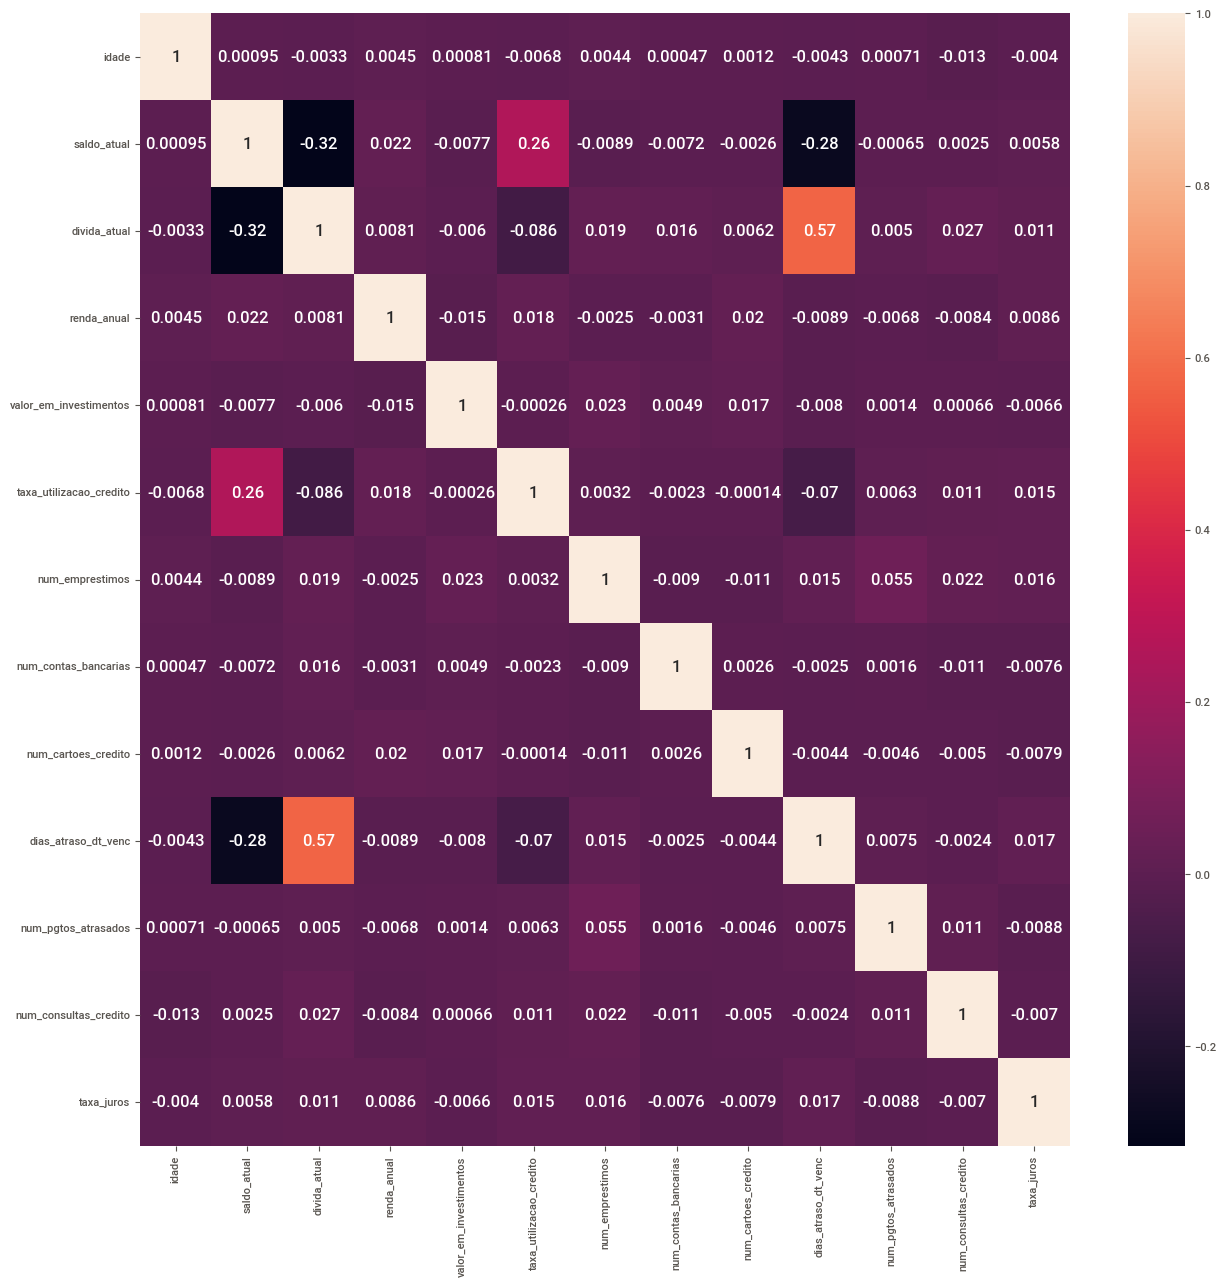

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(df_raw[features + ['limite_adicional']].corr(method='pearson'), annot=True);

# 7.0. Modelos Machine Learning

In [ ]:
df7 = df6.copy()

In [ ]:
AMBIENTE_DEV = False

In [ ]:
if AMBIENTE_DEV:
    X_train, X_test, y_train, y_test = train_test_split(df7[features], 
                                                        df7['limite_adicional'], 
                                                        test_size=0.2, 
                                                        random_state=42)

In [ ]:
if not AMBIENTE_DEV:
    # X_train = df7[features]
    # y_train = df7['limite_adicional']
    X_train = df_raw[features]
    y_train = df_raw['limite_adicional']

In [ ]:
# Encodar var resposta de treino
lim_adi_dict = {'Negar':0, 'Conceder':1}
y_train = y_train.map(lim_adi_dict)

if AMBIENTE_DEV:
    y_test = y_test.map(lim_adi_dict)

In [ ]:
def resultado(algoritmo, treino, teste, report, resultados):
    # resultados = pd.DataFrame(data=[['', 0.0, 0.0, '']], columns=['algoritmo', 'treino', 'teste', 'report'])
    return pd.concat([resultados,
        pd.DataFrame([{'algoritmo': algoritmo,
                    'treino': treino,
                    'teste': teste,
                    'report': report}])
    ]).sort_values('teste', ascending=False)
resultados = pd.DataFrame()

## Outra abordagem

In [ ]:
# !pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# evaluate knn on the box-cox sonar dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

from category_encoders.count import CountEncoder
from imblearn.over_sampling import KMeansSMOTE

# Sampling
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC
from collections import Counter

In [ ]:
features = ['idade', 
            'saldo_atual', 
            'divida_atual', 
            'renda_anual',
            'valor_em_investimentos', 
            'taxa_utilizacao_credito', 
            'num_emprestimos',
            'num_contas_bancarias', 
            'num_cartoes_credito', 
            'dias_atraso_dt_venc',
            'num_pgtos_atrasados', 
            'num_consultas_credito', 
            'taxa_juros',
            # 'investe_exterior', 
            # 'pessoa_polit_exp'
            ]

In [ ]:

# df7['pessoa_polit_exp'] = LabelEncoder().fit_transform(df7['pessoa_polit_exp'].astype('str'))
# df7['investe_exterior'] = LabelEncoder().fit_transform(df7['investe_exterior'].astype('str'))
df_modelo = df_raw.copy()

le_cat = LabelEncoder()

# df['idade'] = df['idade'].apply(lambda x: x if x <= 101 else df['idade'].median())
# df['num_contas_bancarias'] = df['num_contas_bancarias'].apply(lambda x: x if x <= df['num_contas_bancarias'].quantile(0.95) else df['num_contas_bancarias'].median())
# df['num_contas_bancarias'] = df['num_contas_bancarias'].apply(lambda x: x if x <= df['num_contas_bancarias'].quantile(0.95) else df['num_contas_bancarias'].quantile(0.99))
# df['num_consultas_credito'] = df['num_consultas_credito'].apply(lambda x: x if x <= df['num_consultas_credito'].quantile(0.98) else df['num_consultas_credito'].quantile(0.99))
# df['num_pgtos_atrasados'] = df['num_pgtos_atrasados'].apply(lambda x: x if x <= df['num_pgtos_atrasados'].quantile(0.99) else df['num_pgtos_atrasados'].quantile(0.99))
# df['taxa_juros'] = df['taxa_juros'].apply(lambda x: x if x <= df['taxa_juros'].quantile(0.98) else df['taxa_juros'].quantile(0.98))


# df_modelo['investe_exterior'] = le_cat.fit_transform(df_modelo['investe_exterior'].astype('str'))
# df_modelo['pessoa_polit_exp'] = le_cat.fit_transform(df_modelo['pessoa_polit_exp'].astype('str'))

In [ ]:

X, y = df_modelo.drop(['id_cliente', 'limite_adicional','investe_exterior', 'pessoa_polit_exp'],axis=1), df_modelo['limite_adicional']

X = X.astype('float32')
y = LabelEncoder().fit_transform(y.astype('str'))

over = {
    0: 7995,
    1: 7995}

smote_tomek = SMOTETomek(random_state=42)
x_smote, y_smote = smote_tomek.fit_resample(X[features], y)


# col_encoder = ['investe_exterior', 'pessoa_polit_exp']
# ce = CountEncoder(cols=col_encoder)

scaler = MinMaxScaler(feature_range=(1, 2))
power = PowerTransformer(method='box-cox')
model = GradientBoostingClassifier(random_state=42)
# model = XGBClassifier(random_state=42)

pipeline = Pipeline(steps=[#('ce', ce), 
                           ('s', scaler),
                           ('p', power), 
                           ('m', model)])

# evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise') #f1_weighted
n_scores = cross_val_score(pipeline, x_smote, y_smote, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise') #f1_weighted

# report pipeline performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.923 (0.006)


In [ ]:
### reading testing dataset
test = pd.read_csv("files/test.csv")
#X_new = test.drop(['id_cliente','investe_exterior','pessoa_polit_exp'],axis=1)
# separate into input and output columns
X_new = test.drop(['id_cliente','investe_exterior','pessoa_polit_exp'],axis=1)
# ensure inputs are floats and output is an integer label

# le = LabelEncoder()
# X_new['investe_exterior'] = le.fit_transform(X_new['investe_exterior'])
# X_new['pessoa_polit_exp'] = le.fit_transform(X_new['pessoa_polit_exp'])

# X_new = X_new.astype('float32')

flag_index = X_new.loc[X_new.idade>100].index
X_new['flag_idade'] = 0
X_new.loc[flag_index, 'flag_idade'] = 1

pipeline.fit(X,y)
# Fazer a previsão do score usando o modelo final treinado:
yhat_xgboost_ktest = pipeline.predict(X_new)

# Preparação para submissão
# Criar dataset final
df_sub = pd.concat([test['id_cliente'], pd.Series(yhat_xgboost_ktest, name='limite_adicional')], axis=1)
# Traduzir var resposta
#lim_adi_dic_final = {0 : 'Negar', 1: 'Conceder'}
lim_adi_dic_final = {1 : 'Negar', 0: 'Conceder'}


df_sub['limite_adicional'] = df_sub['limite_adicional'].map( lim_adi_dic_final )
# Visutalizar arquivo final para submissão ao Kaggle
display(df_sub[:5])
# Gerar export para submission no Kaggle
df_sub.to_csv('submissions/gbc_minmax_boxcox_smote_flag.csv', index=False) 

Accuracy: 0.879 (0.008)

In [ ]:
n_scoresf1 = cross_val_score(pipeline, x_smote, y_smote, scoring='f1_weighted', cv=cv, n_jobs=-1, error_score='raise') #f1_weighted
print('F1: %.3f (%.3f)' % (mean(n_scoresf1), std(n_scoresf1)))

F1: 0.912 (0.007)


In [ ]:
### reading testing dataset
test = pd.read_csv("files/test.csv")
X_new = test.drop(['id_cliente','investe_exterior', 'pessoa_polit_exp'],axis=1)

# X_new['investe_exterior'] = le_cat.transform(X_new['investe_exterior'].astype('str'))
# X_new['pessoa_polit_exp'] = le_cat.transform(X_new['pessoa_polit_exp'].astype('str'))

pipeline.fit(x_smote, y_smote)
# Fazer a previsão do score usando o modelo final treinado:
yhat_xgboost_ktest = pipeline.predict(X_new)

# Preparação para submissão
# Criar dataset final
df_sub = pd.concat([test['id_cliente'], pd.Series(yhat_xgboost_ktest, name='limite_adicional')], axis=1)
# Traduzir var resposta
#lim_adi_dic_final = {0 : 'Negar', 1: 'Conceder'}
lim_adi_dic_final = {1 : 'Negar', 0: 'Conceder'}

df_sub['limite_adicional'] = df_sub['limite_adicional'].map( lim_adi_dic_final )
# Visutalizar arquivo final para submissão ao Kaggle
display(df_sub[:5])
# Gerar export para submission no Kaggle
df_sub.to_csv('gbc_minmax_sm.csv', index=False) 

FloatingPointError: ignored

In [ ]:
parameters = {
    "m__loss":["deviance"],    
    "m__max_depth":[3,5,10],    
    "m__n_estimators":[10, 20, 50, 100]
}
# {'gb__loss': 'deviance', 'gb__max_depth': 3, 'gb__n_estimators': 50}

# parameters = {
#     "gb__loss":["deviance"],
#     # "gb__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#     "gb__max_depth":[3],
#     # "gb__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
#     "gb__n_estimators":[50],
#     # "min_samples_split": np.linspace(0.1, 0.5, 12),
#     # "min_samples_leaf": np.linspace(0.1, 0.5, 12),    
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
    
#     }

scaler = MinMaxScaler(feature_range=(1, 2))
power = PowerTransformer(method='box-cox')
model = GradientBoostingClassifier(random_state=42)
# model = XGBClassifier(random_state=42)
pipeline = Pipeline(steps=[('s', scaler),('p', power), ('m', model)])


kfold = KFold(n_splits=10, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid=parameters, cv=kfold, n_jobs=-1)
grid.fit(X, y)
grid.best_params_ 

{'m__loss': 'deviance', 'm__max_depth': 3, 'm__n_estimators': 50}

## 7.1. Arvore de Decisão

In [ ]:
model_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=42))
])

# treinando o modelo
model_tree.fit(X_train, y_train)

if AMBIENTE_DEV:
    yhat_tree = model_tree.predict(X_test)

    # Gerando resultados
    # print(classification_report(yhat_tree, y_test))

    resultados = resultado('DecisionTreeClassifier',
            model_tree.score(X_train, y_train), 
            model_tree.score(X_test, y_test),
            classification_report(yhat_tree, y_test),
            resultados)
    # resultados.update({'tree_train': model_tree.score(X_train, y_train)})
    # resultados.update({'tree_test': model_tree.score(X_test, y_test)})

In [ ]:
# resultados['tree_train'] = 1#model_tree.score(X_train, y_train)
# resultados['tree_test'] = 2#model_tree.score(X_test, y_test)
# resultados

In [ ]:
# # avaliando o modelo
# train_score = model.score(X_train, y_train)
# test_score = model.score(X_test, y_test)

# print("Train score: {}".format(train_score))
# print("Test score: {}".format(test_score))
# # OUTPUT
# # Train score: 0.8342696629213483
# # Test score: 0.7988826815642458

## 7.2. XGBoost

In [ ]:
import xgboost as xgb

model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('XGBClassifier', xgb.XGBClassifier(random_state=42))
])

# # treinando o modelo
# model_xgb.fit(X_train, y_train)

# if AMBIENTE_DEV:
#     yhat_xgb = model_xgb.predict(X_test)

#     # Gerando resultados
#     print(classification_report(yhat_tree, y_test));

#     # resultados.update({'xgb_train': model_xgb.score(X_train, y_train)})
#     # resultados.update({'xgb_test': model_xgb.score(X_test, y_test)})

#     resultados = resultado('XGBClassifier', 
#             model_xgb.score(X_train, y_train), 
#             model_xgb.score(X_test, y_test),
#             classification_report(yhat_xgb, y_test),
#             resultados)

In [ ]:
validacao_cruzada = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model_xgb, X_train, y_train, cv=10)
scores.mean()

0.8789473684210526

In [ ]:
# sorted_idx = model_xgb[1].feature_importances_.argsort()
# X_train.columns[sorted_idx]
# model_xgb[1].feature_importances_[sorted_idx]
# plt.barh(X_train.columns[sorted_idx], model_xgb[1].feature_importances_[sorted_idx])
# plt.xlabel("Xgboost Feature Importance")

## 7.3. Extra Trees Classifier

In [ ]:
model_extratree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ExtraTreesClassifier', ExtraTreesClassifier(random_state=42))
])

# treinando o modelo
model_extratree.fit(X_train, y_train)

if AMBIENTE_DEV:
    yhat_extratree = model_extratree.predict(X_test)

    # Gerando resultados
    # print(classification_report(yhat_extratree, y_test));
    # resultados.update({'extratree_train': model_extratree.score(X_train, y_train)})
    # resultados.update({'extratree_test': model_extratree.score(X_test, y_test)})
    resultados = resultado('ExtraTreesClassifier', 
            model_extratree.score(X_train, y_train), 
            model_extratree.score(X_test, y_test),
            classification_report(yhat_extratree, y_test),
            resultados)

## 7.4. Regressão Logistica

In [ ]:
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('LogisticRegression', LogisticRegression(random_state=42))
])

# treinando o modelo
model_lr.fit(X_train, y_train)

if AMBIENTE_DEV:
    yhat_lr = model_lr.predict(X_test)

    # Gerando resultados
    # print(classification_report(yhat_lr, y_test));
    # resultados.update({'lr_train': model_lr.score(X_train, y_train)})
    # resultados.update({'lr_test': model_lr.score(X_test, y_test)})

    resultados = resultado('LogisticRegression', 
            model_lr.score(X_train, y_train), 
            model_lr.score(X_test, y_test),
            classification_report(yhat_lr, y_test),
            resultados)

## 7.5. Random Forest Classifier

In [ ]:
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('RandomForest', RandomForestClassifier(random_state=42))
])

# treinando o modelo
model_rf.fit(X_train, y_train)

if AMBIENTE_DEV:
    yhat_rf = model_rf.predict(X_test)

    # Gerando resultados
    # print(classification_report(yhat_rf, y_test));
    # resultados.update({'rf_train': model_rf.score(X_train, y_train)})
    # resultados.update({'rf_test': model_rf.score(X_test, y_test)})

    resultados = resultado('RandomForest', 
            model_rf.score(X_train, y_train), 
            model_rf.score(X_test, y_test),
            classification_report(yhat_rf, y_test),
            resultados)

## 7.5. Gradient Boosting Classifier

In [ ]:
model_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('GradientBoosting', GradientBoostingClassifier(random_state=42))
                                    # #     ccp_alpha=0.0, 
                                    # #   criterion='friedman_mse', 
                                    # #   init=None, 
                                    # #   learning_rate=0.1, 
                                    #   loss='deviance', 
                                    #   max_depth=3, 
                                    # #   max_features=None, 
                                    # #   max_leaf_nodes=None, 
                                    # #   min_impurity_decrease=0.0,                                     
                                    # #   min_samples_leaf=1, 
                                    # #   min_samples_split=2, 
                                    # #   min_weight_fraction_leaf=0.0, 
                                    #   n_estimators=100, 
                                    #   random_state=42))
])

# treinando o modelo
model_gb.fit(X_train, y_train)

if AMBIENTE_DEV:
    yhat_gb = model_gb.predict(X_test)

    # Gerando resultados
    # print(classification_report(yhat_gb, y_test));
    # resultados.update({'gb_train': model_gb.score(X_train, y_train)})
    # resultados.update({'gb_test': model_gb.score(X_test, y_test)})

    resultados = resultado('GradientBoosting', 
            model_gb.score(X_train, y_train), 
            model_gb.score(X_test, y_test),
            classification_report(yhat_gb, y_test),
            resultados)

### aaaa

In [ ]:


# smt = SMOTE(random_state=42)

# model_gb = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('smt', smt),
#     ('GradientBoosting', GradientBoostingClassifier(random_state=42))
# ])

# # treinando o modelo
# saida = model_gb.fit(X_train, y_train)


In [ ]:
# validacao_cruzada = KFold(n_splits=10, shuffle=True, random_state=42)
# scores = cross_val_score(model_gb, X_train, y_train, cv=10)
# scores.mean()

0.8771578947368421

In [ ]:
# from collections import Counter
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split as tts
# from sklearn.decomposition import PCA
# from sklearn.neighbors import KNeighborsClassifier as KNN
# from sklearn.metrics import classification_report
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline 
# X, y = make_classification(n_classes=2, class_sep=2,
# weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
# n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
# print(f'Original dataset shape {Counter(y)}')

# pca = PCA()
# smt = SMOTE(random_state=42)
# knn = KNN()
# knn = GradientBoostingClassifier(random_state=42)
# pipeline = Pipeline([('smt', smt), ('pca', pca), ('knn', knn)])
# X_train2, X_test2, y_train2, y_test2 = tts(X, y, random_state=42)
# pipeline.fit(X_train2, y_train2) 

# y_hat = pipeline.predict(X_test)
# print(classification_report(y_test, y_hat))

Original dataset shape Counter({1: 900, 0: 100})
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        26
           1       0.99      1.00      0.99       224

    accuracy                           0.99       250
   macro avg       0.99      0.94      0.97       250
weighted avg       0.99      0.99      0.99       250



## 7.5. Comparação de Modelos

In [ ]:
if AMBIENTE_DEV:
    print(resultados.sort_values('teste', ascending=False).reset_index()['algoritmo'][0])
    print(resultados.sort_values('teste', ascending=False).reset_index()['report'][0])
    print(resultados.sort_values('teste', ascending=False).reset_index())
    resultados.to_csv('resultado_treino_teste1.csv', index=False)

In [ ]:
evaluate(model_gb, X_train, y_train, 10)

***Modelo: GradientBoosting***
F1 Weighted: 0.873 +/- 0.012
Recall:      0.500 +/- 0.041
Precision:   0.660 +/- 0.059
F1 ALL: [0.85580594 0.87075134 0.87129334 0.86383335 0.86114021 0.8954195
 0.85946824 0.88563459 0.87889193 0.88441921]



In [ ]:
evaluate(model_gb, X_train, y_train, 10)


***Modelo: GradientBoosting***
F1 Weighted: 0.871 +/- 0.011
Recall:      0.491 +/- 0.038
Precision:   0.656 +/- 0.058
F1 ALL: [0.85784376 0.86772038 0.86677732 0.86255206 0.85891846 0.89325804
 0.86829262 0.8810939  0.87096987 0.8799574 ]



In [ ]:
modelos = [model_tree, model_xgb, model_extratree, model_lr, model_rf, model_gb]

# if AMBIENTE_DEV:
for modelo in modelos:
    evaluate(modelo, X_train, y_train, 5)

***Modelo: DecisionTreeClassifier***
F1 Weighted: 0.844 +/- 0.006
Recall:      0.515 +/- 0.024
Precision:   0.507 +/- 0.021
F1 ALL: [0.83664477 0.84210526 0.84567928 0.84078115 0.85574595]

***Modelo: XGBClassifier***
F1 Weighted: 0.870 +/- 0.007
Recall:      0.468 +/- 0.029
Precision:   0.668 +/- 0.028
F1 ALL: [0.86117664 0.86170482 0.87031242 0.87718943 0.87855822]

***Modelo: ExtraTreesClassifier***
F1 Weighted: 0.843 +/- 0.009
Recall:      0.322 +/- 0.036
Precision:   0.632 +/- 0.042
F1 ALL: [0.83417402 0.83271487 0.84699679 0.84698459 0.85627701]

***Modelo: LogisticRegression***
F1 Weighted: 0.807 +/- 0.006
Recall:      0.165 +/- 0.024
Precision:   0.500 +/- 0.037
F1 ALL: [0.7959119  0.80315291 0.80780904 0.8127581  0.81290019]

***Modelo: RandomForest***
F1 Weighted: 0.866 +/- 0.006
Recall:      0.456 +/- 0.024
Precision:   0.652 +/- 0.036
F1 ALL: [0.85962923 0.85699097 0.86849365 0.87023722 0.87359173]

***Modelo: GradientBoosting***
F1 Weighted: 0.868 +/- 0.007
Recall:      0.

***Modelo: DecisionTreeClassifier***
F1 Weighted: 0.845 +/- 0.004
Recall:      0.534 +/- 0.007
Precision:   0.507 +/- 0.015
F1 ALL: [0.839942   0.84307737 0.85010092 0.84472668 0.84862458]

***Modelo: XGBClassifier***
F1 Weighted: 0.869 +/- 0.007
Recall:      0.457 +/- 0.022
Precision:   0.672 +/- 0.039
F1 ALL: [0.86056082 0.86002883 0.87519007 0.87293043 0.87470159]

***Modelo: ExtraTreesClassifier***
F1 Weighted: 0.860 +/- 0.004
Recall:      0.385 +/- 0.013
Precision:   0.692 +/- 0.035
F1 ALL: [0.8573186  0.8542739  0.86442427 0.85922125 0.86434773]

***Modelo: LogisticRegression***
F1 Weighted: 0.852 +/- 0.009
Recall:      0.375 +/- 0.039
Precision:   0.633 +/- 0.033
F1 ALL: [0.8522726  0.84262132 0.85384261 0.84374203 0.86706771]

***Modelo: RandomForest***
F1 Weighted: 0.866 +/- 0.006
Recall:      0.439 +/- 0.021
Precision:   0.674 +/- 0.051
F1 ALL: [0.86131282 0.85705251 0.87423728 0.86657249 0.86999317]

***Modelo: GradientBoosting***
F1 Weighted: 0.867 +/- 0.006
Recall:      0.474 +/- 0.023
Precision:   0.645 +/- 0.028
F1 ALL: [0.85962923 0.86099626 0.86764817 0.87227387 0.87585466]

## 7.6. Cross Validation

# 8.0. Hyperparameter Fine Tuning

## 8.1. Grid Search

In [ ]:

parameters = {
    "gb__loss":["deviance"],    
    "gb__max_depth":[3,5,10],    
    "gb__n_estimators":[10, 20, 50, 100, 500]
}
# {'gb__loss': 'deviance', 'gb__max_depth': 3, 'gb__n_estimators': 50}

parameters = {
    "gb__loss":["deviance"],
    # "gb__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "gb__max_depth":[3],
    # "gb__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "gb__n_estimators":[50],
    # "min_samples_split": np.linspace(0.1, 0.5, 12),
    # "min_samples_leaf": np.linspace(0.1, 0.5, 12),    
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    
    }

# parameters = {'n_estimators': [10, 20]}
# def modelo_parameters(modelo, parametros):
#     for i in parametros.keys():
#         print(i)

# modelo_parameters('gb', parameters)


In [ ]:
model_gs = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gb', GradientBoostingClassifier(random_state=42))
])

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(model_gs, param_grid=parameters, cv=kfold, n_jobs=-1)
grid.fit(X=X_train, y=y_train)
grid.best_params_ 

In [ ]:
# {'gb__loss': 'deviance', 'gb__max_depth': 3, 'gb__n_estimators': 50}

## 8.2. Modelo Final

# 9.0. Aplicando nos Dados de Teste

## Classificação dados de Validação e submissão

In [ ]:
# modelos = [model_tree, model_xgb, model_extratree, model_lr, model_rf, model_gb]
modelo_final = model_rf

if not AMBIENTE_DEV:
    yhat_final = modelo_final.predict(df_validacao)

    submissao = pd.DataFrame(yhat_final, columns=['limite_adicional'])
    submissao['id_cliente'] = df_validacao['id_cliente'].reset_index(drop=True)
    submissao = submissao[['id_cliente', 'limite_adicional']]
    
    # Traduzir var resposta
    lim_adi_dic_final = {0 : 'Negar', 1: 'Conceder'}
    submissao['limite_adicional'] = submissao['limite_adicional'].map(lim_adi_dic_final)
    
    # Salva em arquivo
    submissao.to_csv(f'submission_{list(modelo_final.named_steps.keys())[1]}.csv', index=False)
    print(submissao)

In [ ]:
#  RandomForest
#  GradientBoosting
#  XGBClassifier 

In [ ]:
type(df['Survived'])

In [ ]:

type(y_train)